In [1]:
from libs.TrashbinDataset import TrashbinDataset
from libs.TDContainer import TDContainer
from libs.PretrainedModels import PretrainedModelsCreator, AlexNet_cc, SqueezeNet_cc, InceptionV3_cc
from libs.Training import AverageValueMeter, trainval_classifier, test_classifier, accuracy_score
from libs.utils import get_model_name, import_dataset

In [9]:
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim


In [3]:
def init_model(creator: PretrainedModelsCreator, model_name: str, num_classes: int = 3, feature_extract: bool=True, use_pretrained: bool = True):
    print('Init: %s' % (model_name))
    creator.init_model(num_classes=num_classes, feature_extract=feature_extract, use_pretrained=use_pretrained)
    # creator.get_info()
    return creator


In [4]:
# omit num_classes 
alexNet_v1 = init_model(creator=AlexNet_cc(), model_name=get_model_name(model_name='AlexNet', lr='0.01'), feature_extract=True, use_pretrained=True)

Init: AlexNet__lr=0.01


In [ ]:
# type(alexNet_v1)
# alexNet_v1.get_info()

## Test initialize model SqueezeNet, InceptionV3

In [11]:
squeezenet_v1 = init_model(creator=SqueezeNet_cc(), model_name=get_model_name(model_name='SqueezeNet', lr='0.01'), feature_extract=True, use_pretrained=True)

Init: SqueezeNet__lr=0.01


In [ ]:
init_model(creator=InceptionV3_cc(), model_name=get_model_name(model_name='InceptionV3', lr='0.01'), feature_extract=True, use_pretrained=True)

## Test using dataset (dataLoader)

In [6]:
dst_v0 = import_dataset('dataset', 
    train_transform=transforms.Compose([
        transforms.Resize(256),
        # transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     # default dev and std for pretrained models
    ]),
    test_transform=transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), # crop centrale
        # transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN), # NOTA: già su dataset_v2 è stato settato sul train
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     # default dev and std for pretrained models
    ])
)

initialize dataset on PretrainedModel object

In [7]:
alexNet_v1.init_dst(dst_v0, batch_size=64, num_workers=2, drop_last=True)

In [7]:
alexNet_v1.dst.training_loader

Show dataLoaders images:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


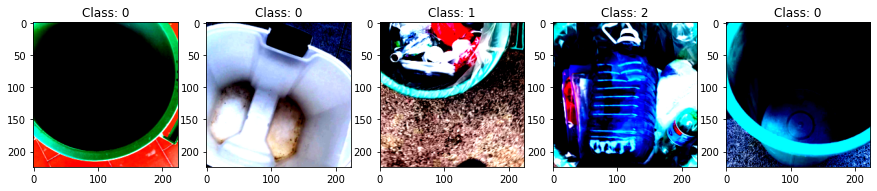

In [15]:
train_dataloader = alexNet_v1.dst.training_loader

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.title("Class: %s" % train_labels[0].numpy())
    img = train_features[0].squeeze()
    label = train_labels[0]

    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    train_features, train_labels = next(iter(train_dataloader))
plt.show()

## Create the optimizer -- todo
https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [18]:
model_ft = squeezenet_v1.get_model()    # testo con quello presente sull esempio per vedere se ho fatto bene

# Send the model to GPU
model_ft = model_ft.to(device) ## da integrareee

#### da integrare nella classe principale

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")

feature_extract = True

if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


## TO DO INTERAMENTE

- run training e validation step (il codice di training)
- adatta a quella precedente
- inserisci il codice precedente 


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))